# Python

*** 

## 1. Python import and define functions

In [1]:
import os
import copy
import random
import collections
import itertools
import numpy as np
import pandas as pd
import lightgbm as lgb
import warnings
from sklearn import svm
from sklearn.externals import joblib
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split,RandomizedSearchCV
import sklearn.metrics as metrics
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

In [2]:
# Whether in jupyter notebook
def isnotebook() -> bool:
    """
    Returns True if the current execution environment is a jupyter notebook
    https://stackoverflow.com/questions/15411967/how-can-i-check-if-code-is-executed-in-the-ipython-notebook
    """
    try:
        shell = get_ipython().__class__.__name__
        if shell == 'ZMQInteractiveShell':
            return True   # Jupyter notebook or qtconsole
        elif shell == 'TerminalInteractiveShell':
            return False  # Terminal running IPython
        else:
            return False  # Other type (?)
    except NameError:
        return False      # Probably standard Python interpreter

In [3]:
#get filepath of input and output
def get_filepath():
    parser = argparse.ArgumentParser()
    parser.add_argument("-C","-c","--cyto",dest = "cytosol", help = "Cytosol instances file")
    parser.add_argument("-N","-n","--nuc",dest = "nuclear",help = "Nuclear instances file")
    args = parser.parse_args()
    return args

In [4]:
# Count the frequency of k-mer in each RNA sequence
# k-mer was normalized by total k-mer count of each RNA sequence
def _count_kmer(Dataset,k): # k = 3,4,5
    
    # copy dataset
    dataset = copy.deepcopy(Dataset)
    # alphbet of nucleotide
    nucleotide = ['A','C','G','T']
    
    # generate k-mers
    #  k == 5:
    five = list(itertools.product(nucleotide,repeat=5))
    pentamer = []
    for n in five:
        pentamer.append("".join(n))
    
    #  k == 4:
    four = list(itertools.product(nucleotide,repeat=4))
    tetramer = []
    for n in four:
        tetramer.append("".join(n))

    # k == 3:
    three = list(itertools.product(nucleotide,repeat=3))
    threemer = []
    for n in three:
        threemer.append("".join(n))
    
    # input features can be combinations of diffrent k values
    if k == 34:
        table_kmer = dict.fromkeys(threemer,0)
        table_kmer.update(dict.fromkeys(tetramer,0))
    if k == 45:
        table_kmer = dict.fromkeys(tetramer,0)
        table_kmer.update(dict.fromkeys(pentamer,0))
    if k == 345:
        table_kmer = dict.fromkeys(threemer,0)
        table_kmer.update(dict.fromkeys(tetramer,0))
        table_kmer.update(dict.fromkeys(pentamer,0))

    # count k-mer for each sequence
    for mer in table_kmer.keys():
        table_kmer[mer] = dataset["cdna"].apply(lambda x : x.count(mer))
    
    # for k-mer raw count without normalization, index: nuc:1 or cyto:0
    rawcount_kmer_df = pd.DataFrame(table_kmer)
    df1_rawcount = pd.concat([rawcount_kmer_df,dataset["ensembl_transcript_id"]],axis = 1)
    df1_rawcount.index = dataset["tag"]

    # for k-mer frequency with normalization , index: nuc:1 or cyto:0
    freq_kmer_df = rawcount_kmer_df.apply(lambda x: x/x.sum(),axis=1)
    df1 = pd.concat([freq_kmer_df,dataset["ensembl_transcript_id"]],axis = 1)
    df1.index = dataset["tag"]

    return df1,df1_rawcount

In [5]:
#Evaluate performance of model
def evaluate_performance(y_test, y_pred, y_prob):
    # AUROC
    auroc = metrics.roc_auc_score(y_test,y_prob)
    auroc_curve = metrics.roc_curve(y_test, y_prob)
    # AUPRC
    auprc=metrics.average_precision_score(y_test, y_prob) 
    auprc_curve=metrics.precision_recall_curve(y_test, y_prob)
    #Accuracy
    accuracy=metrics.accuracy_score(y_test,y_pred) 
    #MCC
    mcc=metrics.matthews_corrcoef(y_test,y_pred)
    
    recall=metrics.recall_score(y_test, y_pred)
    precision=metrics.precision_score(y_test, y_pred)
    f1=metrics.f1_score(y_test, y_pred)
    class_report=metrics.classification_report(y_test, y_pred,target_names = ["control","case"])

    model_perf = {"auroc":auroc,"auroc_curve":auroc_curve,
                  "auprc":auprc,"auprc_curve":auprc_curve,
                  "accuracy":accuracy, "mcc": mcc,
                  "recall":recall,"precision":precision,"f1":f1,
                  "class_report":class_report}
        
    return model_perf

In [6]:
# Output result of evaluation
def eval_output(model_perf,path):
    with open(os.path.join(path,"Evaluate_Result_TestSet.txt"),'w') as f:
        f.write("AUROC=%s\tAUPRC=%s\tAccuracy=%s\tMCC=%s\tRecall=%s\tPrecision=%s\tf1_score=%s\n" %
               (model_perf["auroc"],model_perf["auprc"],model_perf["accuracy"],model_perf["mcc"],model_perf["recall"],model_perf["precision"],model_perf["f1"]))
        f.write("\n######NOTE#######\n")
        f.write("#According to help_documentation of sklearn.metrics.classification_report:in binary classification, recall of the positive class is also known as sensitivity; recall of the negative class is specificity#\n\n")
        f.write(model_perf["class_report"])

In [7]:
# Plot AUROC of model
def plot_AUROC(model_perf,path):
    #get AUROC,FPR,TPR and threshold
    roc_auc = model_perf["auroc"]
    fpr,tpr,threshold = model_perf["auroc_curve"]
    #return AUROC info
    temp_df = pd.DataFrame({"FPR":fpr,"TPR":tpr})
    temp_df.to_csv(os.path.join(path,"AUROC_info.txt"),header = True,index = False, sep = '\t')
    #plot
    plt.figure()
    lw = 2
    plt.figure(figsize=(10,10))
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='AUROC (area = %0.2f)' % roc_auc) 
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("AUROC of Models")
    plt.legend(loc="lower right")
    plt.savefig(os.path.join(path,"AUROC_TestSet.pdf"),format = "pdf")

*** 
###   

## 2. Configution

In [8]:
# Random seed
SEED = 1234
random.seed(SEED)
np.random.seed(SEED)

# Index of model performance
ModelPerf = collections.namedtuple('ModelPerf',
                                   ['auroc', 'auroc_curve', 'auprc', 'auprc_curve', 'accuracy', 'mcc'
                                    'recall', 'precision', 'f1', 'class_report','ce_loss'])
warnings.filterwarnings(action='ignore')

# Output dir
output_dir = "01_ML_Model_Output"
if not (os.path.exists(output_dir)):
    os.mkdir(output_dir)

*** 
###   

## 3. Data Processing

In [10]:
%%time
print("\n********************** Start Data Processing **************************")

# get input_file path
if isnotebook():
    cyto_f = "/data/rnomics8/yuanguohua/RNAlight_Private/mRNA/02_Dataset/02_mRNA_info_cyto_transcript.tsv"
    nuc_f = "/data/rnomics8/yuanguohua/RNAlight_Private/mRNA/02_Dataset/02_mRNA_info_nuc_transcript.tsv"
else:
    args = get_filepath()
    cyto_f = args.cytosol
    nuc_f = args.nuclear

# load data
dataset_cyto = pd.read_csv(cyto_f,sep='\t',index_col = False)    #2924    
dataset_nuc = pd.read_csv(nuc_f,sep='\t',index_col = False)    #2256
# Set the tag of RCI(log2FC): nuclear 1 / cytosol 0
dataset_nuc['tag'] = 1;dataset_cyto['tag'] = 0
# merge the nuc and cyto dataset
dataset = pd.concat([dataset_nuc,dataset_cyto]) # 5180
# remove duplications(actually,each lncRNA is unique in its class)
dataset.drop_duplicates(keep="first",subset=["ensembl_transcript_id","name","cdna"],inplace=True) # 5180
# k = 3,4,5 count the normalized and raw count of kmer
df_kmer_345,df_kmer_345_rawcount = _count_kmer(dataset,345)
df_kmer_345.to_csv(os.path.join(output_dir,"df_kmer345_freq.tsv"),sep='\t')
df_kmer_345_rawcount.to_csv(os.path.join(output_dir,"df_kmer345_rawcount.tsv"),sep='\t')
# load kmer file
# df_kmer_345 = pd.read_csv(os.path.join(output_dir,"df_kmer345_freq.tsv"),sep='\t',index_col= 0)

# convert to x:kmer-freq , y:label
del df_kmer_345['ensembl_transcript_id']
x_kmer = df_kmer_345.values
y_kmer = y_kmer = np.array(df_kmer_345.index)
# split into training and test sets (9:1)
x_train, x_test, y_train, y_test = train_test_split(x_kmer, y_kmer, test_size = 0.1, random_state = SEED)

print("\n********************** Finished Data Processing ***********************")


********************** Start Data Processing **************************

********************** Finished Data Processing ***********************
CPU times: user 2min 22s, sys: 2.33 s, total: 2min 25s
Wall time: 3min 30s


*** 
###   

## 3. Model Construction & Evaluation

- SVM


*** SVM ***
CPU times: user 4min 11s, sys: 3.63 s, total: 4min 15s
Wall time: 10h 54min 34s


['01_ML_Model_Output/SVM/best_SVM_model.pkl']

<Figure size 432x288 with 0 Axes>

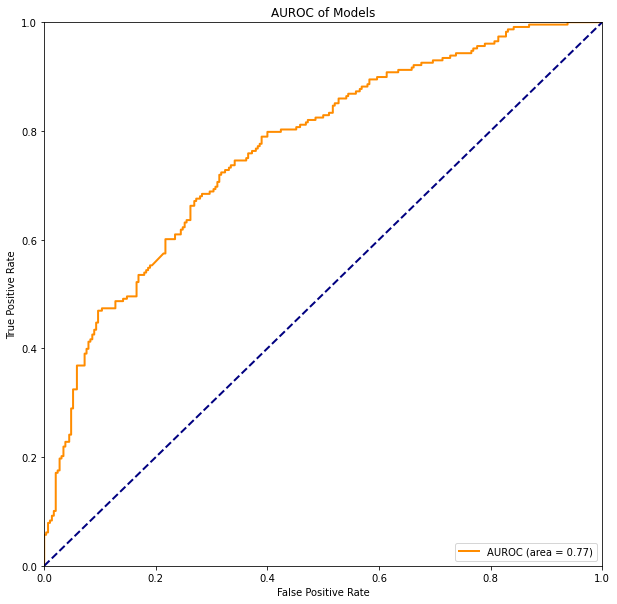

In [13]:
%%time
#Construct SVM model
print("\n*** SVM ***")

# SVM params
SVM_param_dict = {
    'kernel':('linear', 'rbf'), 
    # previous_C: [0.01,0.1,1,10, 100]
    'C':np.linspace(1e-3,1e3,100), 
    # previous_gamma: [0.001, 0.005, 0.1 ,0.5,1, 2]
    'gamma':np.linspace(1e-3,1e3,100),
    
    "probability":[True],
    "random_state":[SEED]
}

#Initiate model
SVM_model = svm.SVC()
#Adjust hyper-parameters with 5-fold cross validation
SVM_rscv = RandomizedSearchCV(SVM_model, SVM_param_dict, n_iter=1000,cv = 5,verbose = 0,
                          scoring = "roc_auc",random_state=SEED,n_jobs = 40)
SVM_rscv.fit(x_train, y_train) 


#Evaluate best SVM model
#Output path
path = os.path.join(output_dir,"SVM")
if not (os.path.exists(path)):
    os.mkdir(path)
    
# Model performance(AUROC) on cross-validation dataset
SVM_cv_perf = np.array([ SVM_rscv.cv_results_["split%s_test_score"%str(i)] for i in range(5)])[:,SVM_rscv.best_index_]

#Get best model with score [max(mean(auc(5 cross validation)))]
svm_best_model = SVM_rscv.best_estimator_
#Get predict_class(y_pred) and predict_probality_for_case(y_prob) of TestSet
y_pred = svm_best_model.predict(x_test)
y_prob = svm_best_model.predict_proba(x_test)[:,1]

#Get model performance
model_perf = evaluate_performance(y_test,y_pred,y_prob)
#Output result of evaluation
eval_output(model_perf,path)
#You can make bar plot consisted of accuracy,sensitivity,specificity,auroc,f1 score,MCC,precision,recall,auprc according to the "Evaluate_Result_TestSet.txt"
# Plot AUROC
plot_AUROC(model_perf,path)

#save model
joblib.dump(svm_best_model,os.path.join(path,"best_SVM_model.pkl"))
#load model
#svm_best_model = joblib.load(os.path.join(path,"best_SVM_model.pkl"))
######################################

- LightGBM


*** LightGBM ***
CPU times: user 2min 7s, sys: 4.8 s, total: 2min 11s
Wall time: 13h 22min 25s


['01_ML_Model_Output/LightGBM/best_LightGBM_model.pkl']

<Figure size 432x288 with 0 Axes>

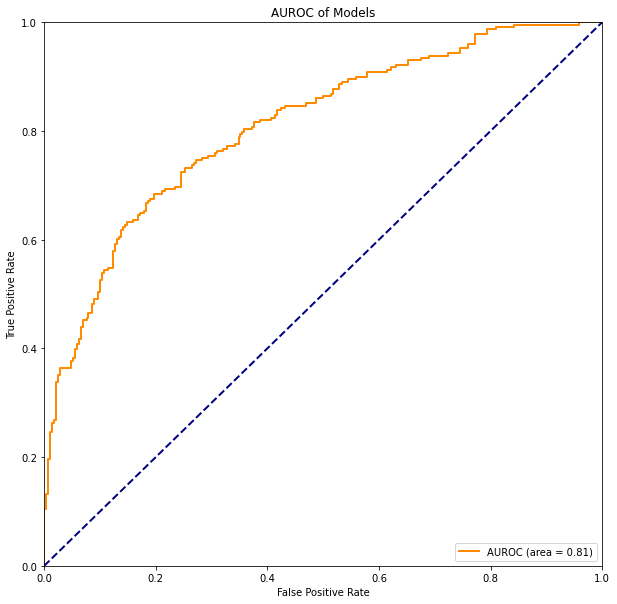

In [23]:
%%time
print("\n*** LightGBM ***")

# LightGBM params
lgb_param_dict = {
    # previous_learning_rate:[0.1, 0.05, 0.02, 0.01]
    "learning_rate":np.logspace(-5,-1,10),
    # previous_num_leaves": range(10,36,5)
    "num_leaves": range(10,100,5),
    # previous_max_depth : [2,3,4,5,10,20,40,50]
    "max_depth" : range(1,50,2),
    # previous_n_estimators : range(100,2500,100)
    "n_estimators" : range(1,2500,10),
    
    "min_child_samples": range(1, 45, 2),
    "colsample_bytree" : [i / 10 for i in range(2,11)],
    "metric" : ["binary_logloss"],
    "n_jobs":[1],
    "subsample" :  [i / 10 for i in range(2, 11)],
    "subsample_freq" : [0, 1, 2],
    "reg_alpha" : [0, 0.001, 0.005, 0.01, 0.1],
    "reg_lambda" : [0, 0.001, 0.005, 0.01, 0.1],
    "objective":["binary"],
    "random_state":[SEED]
}

#Initiate model
lgb_model = lgb.LGBMClassifier()
#Adjust hyper-parameters with 5-fold cross validation
lgb_rscv = RandomizedSearchCV(lgb_model, lgb_param_dict, n_iter=1000,cv = 5,verbose = 0,
                          scoring = "roc_auc",random_state=SEED,n_jobs = 40)
lgb_rscv.fit(x_train, y_train)   


#Evaluate best LightGBM model
#Output path
path = os.path.join(output_dir,"LightGBM")
if not (os.path.exists(path)):
    os.mkdir(path)
    
# Model performance(AUROC) on cross-validation dataset
lgb_cv_perf = np.array([ lgb_rscv.cv_results_["split%s_test_score"%str(i)] for i in range(5)])[:,lgb_rscv.best_index_]

#Get best model with score [max(mean(auc(5 cross validation)))]
lgb_best_model = lgb_rscv.best_estimator_
#Get predict_class(y_pred) and predict_probality_for_case(y_prob) of TestSet
y_pred = lgb_best_model.predict(x_test)
y_prob = lgb_best_model.predict_proba(x_test)[:,1]

#Get model performance
model_perf = evaluate_performance(y_test,y_pred,y_prob)
#Output result of evaluation
eval_output(model_perf,path)
#You can make bar plot consisted of accuracy,sensitivity,specificity,auroc,f1 score,MCC,precision,recall,auprc according to the "Evaluate_Result_TestSet.txt"
# Plot AUROC
plot_AUROC(model_perf,path)

#save model
joblib.dump(lgb_best_model,os.path.join(path,"best_LightGBM_model.pkl"))
#load model
#lgb_best_model = joblib.load(os.path.join(path,"best_LightGBM_model.pkl"))

- Logistic Regression


*** Logistic Regression  ***
CPU times: user 25.2 s, sys: 2.45 s, total: 27.7 s
Wall time: 3min 46s


['01_ML_Model_Output/LogisticRegression/best_LogisticRegression_model.pkl']

<Figure size 432x288 with 0 Axes>

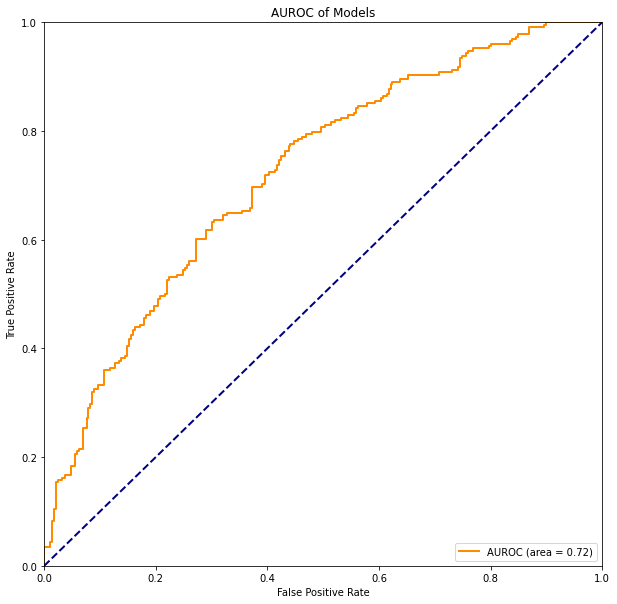

In [26]:
%%time
#Construct Logistic Regression model
print("\n*** Logistic Regression  ***")

# Logistic Regression params
lr_param_dict = {
    "penalty":["l2"],
    # previous_C: [1e-3, 5e-3, 1e-2, 0.05, 0.1, 0.5,1,5,10,50,100,500,1000]
    "C":np.logspace(-5,5,1000),
    "solver":["liblinear"],
    "random_state":[SEED]
}

#Initiate model
lr_model = LogisticRegression()
#Adjust hyper-parameters with 5-fold cross validation
lr_rscv = RandomizedSearchCV(lr_model, lr_param_dict, n_iter=1000,cv = 5,verbose = 0,
                          scoring = "roc_auc",random_state=SEED,n_jobs = 40)
lr_rscv.fit(x_train, y_train)  

#Evaluate best Lasso model
#Output path
path = os.path.join(output_dir,"LogisticRegression")
if not (os.path.exists(path)):
    os.mkdir(path)
    
# Model performance(AUROC) on cross-validation dataset
lr_cv_perf = np.array([ lr_rscv.cv_results_["split%s_test_score"%str(i)] for i in range(5)])[:,lr_rscv.best_index_]

#Get best model with score [max(mean(auc(5 cross validation)))]
lr_best_model = lr_rscv.best_estimator_
#Get predict_class(y_pred) and predict_probality_for_case(y_prob) of TestSet
y_pred = lr_best_model.predict(x_test)
y_prob = lr_best_model.predict_proba(x_test)[:,1]

#Get model performance
model_perf = evaluate_performance(y_test,y_pred,y_prob)
#Output result of evaluation
eval_output(model_perf,path)
#You can make bar plot consisted of accuracy,sensitivity,specificity,auroc,f1 score,MCC,precision,recall,auprc according to the "Evaluate_Result_TestSet.txt"
# Plot AUROC
plot_AUROC(model_perf,path)

#save model
joblib.dump(lr_best_model,os.path.join(path,"best_LogisticRegression_model.pkl"))
#load model
#lgb_best_model = joblib.load(os.path.join(path,"best_LogisticRegression_model.pkl"))

*** 
###   

## 4. Output performance on cross-validation set

In [27]:
ML_CV_result = pd.DataFrame({"SVM":SVM_cv_perf,"lgb":lgb_cv_perf,"lr":lr_cv_perf})
ML_CV_result.to_csv(os.path.join(output_dir,"ML_CV_result.tsv"),sep = '\t',index = False)

*** 
###   

## 5. Output Training set and Test set

In [ ]:
####################### Output TrainingSet and TestSet #######################
# load kmer file
df_kmer_345_out = pd.read_csv(os.path.join(output_dir,"df_kmer345_freq.tsv"),sep='\t',index_col= False)
df_kmer_345_out.index = df_kmer_345_out["ensembl_transcript_id"]
# split into training and test sets (9:1)
X = df_kmer_345_out.iloc[:,1:-2]
y = df_kmer_345_out["tag"]
x_train_out, x_test_out, y_train_out, y_test_out = train_test_split(X, y, test_size = 0.1, random_state = SEED)
# output
TrainingSet_df = dataset[dataset["ensembl_transcript_id"].isin(x_train_out.index)]
TrainingSet_df.to_csv("../mRNA_sublocation_TrainingSet.tsv",sep ='\t',index = False)
TestSet_df = dataset[dataset["ensembl_transcript_id"].isin(x_test_out.index)]
TestSet_df.to_csv("../mRNA_sublocation_TestSet.tsv",sep ='\t',index = False)